In [221]:
from collections import defaultdict
from itertools import product

from tqdm import tqdm
import polars as pl
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['figure.dpi'] = 300
sns.set_palette("colorblind")
# Set font size
plt.rcParams.update({'font.size': 16})

In [222]:
DETECTION_DIR = "detection"
QUANTIFICATION_DIR = "quantification"
OUT_DIR = "../chapters/4_results_and_discussion/figures/detection"
os.makedirs(OUT_DIR, exist_ok=True)
tools = [tool_csv[:-4] for tool_csv in os.listdir(DETECTION_DIR)]
tools

['ciri2', 'circexplorer2', 'find_circ', 'dcc', 'segemehl']

In [223]:
def parse_locstring(locstring: str):
    chrom, coords, strand = locstring.split(":")
    start, end = coords.split("-")
    return {"chr": chrom, "start": int(start), "end": int(end), "strand": strand}

In [224]:
tool_dfs = [
    pl.scan_csv(os.path.join(DETECTION_DIR, f"{tool}.csv"), separator='\t')
        .with_columns(tool=pl.lit(tool))
    for tool in tools
]

samples = tool_dfs[0].drop("id", "tool").collect_schema()

tool_dfs = [df.select("id", "tool", *samples).with_columns(**{sample: pl.col(sample).cast(int) for sample in samples}) for df in tool_dfs]

df = pl.concat(tool_dfs)

df = df.with_columns(
    total_counts=pl.sum_horizontal(samples),
    n_samples=pl.sum_horizontal(pl.col(samples).is_not_null()),
    location=pl.col("id").map_elements(parse_locstring, return_dtype=pl.Struct)
)

df = df.with_columns(
    mean_counts=pl.col("total_counts") / pl.col("n_samples")
)

df = df.with_columns(
    chr=pl.col("location").map_elements(lambda x: x["chr"], return_dtype=str),
    start=pl.col("location").map_elements(lambda x: x["start"], return_dtype=int),
    end=pl.col("location").map_elements(lambda x: x["end"], return_dtype=int),
    strand=pl.col("location").map_elements(lambda x: x["strand"], return_dtype=str)
)

df = df.select("tool", "chr", "start", "end", "strand", "total_counts", "n_samples", "mean_counts")

In [225]:
df = df.with_columns(start=pl.when(pl.col("tool").is_in(["ciri2", "dcc"])).then(pl.col("start") -1).otherwise(pl.col("start")))

In [226]:
df = df.collect().lazy()

In [227]:
df_backup1 = df.clone()

In [248]:
df = df_backup1.clone()

In [249]:
max_shift = 3

df = df.select("chr", "start", "end", "strand", "tool").unique()

df = df.sort("end"  ).with_columns(end_group  =pl.col("end"  ).diff().fill_null(0).gt(max_shift).cum_sum())
df = df.sort("start").with_columns(start_group=pl.col("start").diff().fill_null(0).gt(max_shift).cum_sum())

df_with_groups = df

df = df.group_by("chr", "start", "end", "strand", "start_group", "end_group").agg(tools= pl.col("tool").unique())

group_cols = ["chr", "start_group", "end_group"]
df = df.join(df, on=group_cols, how="inner")
df = df.select("chr", "start", "end", "strand", "start_right", "end_right", "tools_right", "start_group", "end_group")
df = df.filter((pl.col("start") - pl.col("start_right")).abs() <= max_shift)
df = df.filter((pl.col("end") - pl.col("end_right")).abs() <= max_shift)
df = df.group_by("chr", "start", "end", "strand", "start_group", "end_group").agg(
    tools = pl.col("tools_right").flatten().unique()
).sort("chr", "start", "end", "strand")
df = df.with_columns(n_tools=pl.col("tools").map_elements(lambda x: len(x), return_dtype=int))
df = df.filter(pl.col("n_tools") == 5)

df_filtered = df

In [250]:
df = df_with_groups.join(df_filtered, on=["chr", "start", "end", "strand", "start_group", "end_group"], how="inner")
df = df.collect().lazy()
df.collect().head()

chr,start,end,strand,tool,end_group,start_group,tools,n_tools
str,i64,i64,str,str,u32,u32,list[str],i64
"""chr4_JH584295v1_random""",564,1475,"""+""","""dcc""",51,6,"[""segemehl"", ""find_circ"", … ""circexplorer2""]",5
"""chr4_JH584295v1_random""",564,1475,"""+""","""segemehl""",51,6,"[""segemehl"", ""find_circ"", … ""circexplorer2""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""ciri2""",51,6,"[""ciri2"", ""segemehl"", … ""circexplorer2""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""circexplorer2""",51,6,"[""ciri2"", ""segemehl"", … ""circexplorer2""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""find_circ""",51,6,"[""ciri2"", ""segemehl"", … ""circexplorer2""]",5


In [251]:
df = df.drop("tools", "n_tools")
df = df.select("chr", "start", "end", "start_group", "end_group").unique().join(df, on=group_cols, how="inner")
df = df.filter((pl.col("start") - pl.col("start_right")).abs() <= max_shift)
df = df.filter((pl.col("end") - pl.col("end_right")).abs() <= max_shift)
df = df.with_columns(strand=pl.col("strand").map_elements(lambda x: 1 if x == "+" else -1, return_dtype=int))
df = df.collect()
df.head()

chr,start,end,start_group,end_group,start_right,end_right,strand,tool
str,i64,i64,u32,u32,i64,i64,i64,str
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,1,"""dcc"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,1,"""segemehl"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""ciri2"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""circexplorer2"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""find_circ"""


In [252]:
df_mean_locs = df.group_by("chr", "start", "end").agg(
    mean_start=pl.col("start_right").mean(),
    mean_end=pl.col("end_right").mean(),
    mean_strand=pl.col("strand").mean()
)
df_mean_locs.head()

chr,start,end,mean_start,mean_end,mean_strand
str,i64,i64,f64,f64,f64
"""chr1""",60558138,60566648,6.0558138e7,6.0566648e7,-0.2
"""chr2""",65915580,65915733,6.591558e7,6.5915733e7,-0.2
"""chr15""",34116456,34121658,3.4116456e7,3.4121658e7,0.2
"""chr6""",97973334,97987431,9.7973334e7,9.7987431e7,0.2
"""chr1""",9942482,9949300,9.942482e6,9.9493e6,0.2


In [253]:
df = df.join(df_mean_locs, on=["chr", "start", "end"])
df.head()

chr,start,end,start_group,end_group,start_right,end_right,strand,tool,mean_start,mean_end,mean_strand
str,i64,i64,u32,u32,i64,i64,i64,str,f64,f64,f64
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,1,"""dcc""",564.0,1475.0,-0.2
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,1,"""segemehl""",564.0,1475.0,-0.2
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""ciri2""",564.0,1475.0,-0.2
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""circexplorer2""",564.0,1475.0,-0.2
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""find_circ""",564.0,1475.0,-0.2


In [254]:
df = df.with_columns(
    start_delta=pl.col("start_right") - pl.col("mean_start"), 
    end_delta=pl.col("end_right") - pl.col("mean_end"), 
    strand_delta=pl.col("strand") - pl.col("mean_strand")
).select("tool", "start_delta", "end_delta", "strand_delta")
df.head()

tool,start_delta,end_delta,strand_delta
str,f64,f64,f64
"""dcc""",0.0,0.0,1.2
"""segemehl""",0.0,0.0,1.2
"""ciri2""",0.0,0.0,-0.8
"""circexplorer2""",0.0,0.0,-0.8
"""find_circ""",0.0,0.0,-0.8


In [255]:
df.select("start_delta", "end_delta", "strand_delta").describe()

statistic,start_delta,end_delta,strand_delta
str,f64,f64,f64
"""count""",80050.0,80050.0,80050.0
"""null_count""",0.0,0.0,0.0
"""mean""",-1.9790e-11,1.6271e-11,1.0012e-16
"""std""",0.262171,0.266735,0.98064
"""min""",-3.9,-3.181818,-1.666667
"""25%""",0.0,0.0,-0.8
"""50%""",0.0,0.0,0.571429
"""75%""",0.0,0.0,0.8
"""max""",3.375,3.0,1.666667


In [256]:
df = pd.DataFrame(df, columns=df.columns)
df.head()

,tool,start_delta,end_delta,strand_delta
0,dcc,0.0,0.0,1.2
1,segemehl,0.0,0.0,1.2
2,ciri2,0.0,0.0,-0.8
3,circexplorer2,0.0,0.0,-0.8
4,find_circ,0.0,0.0,-0.8


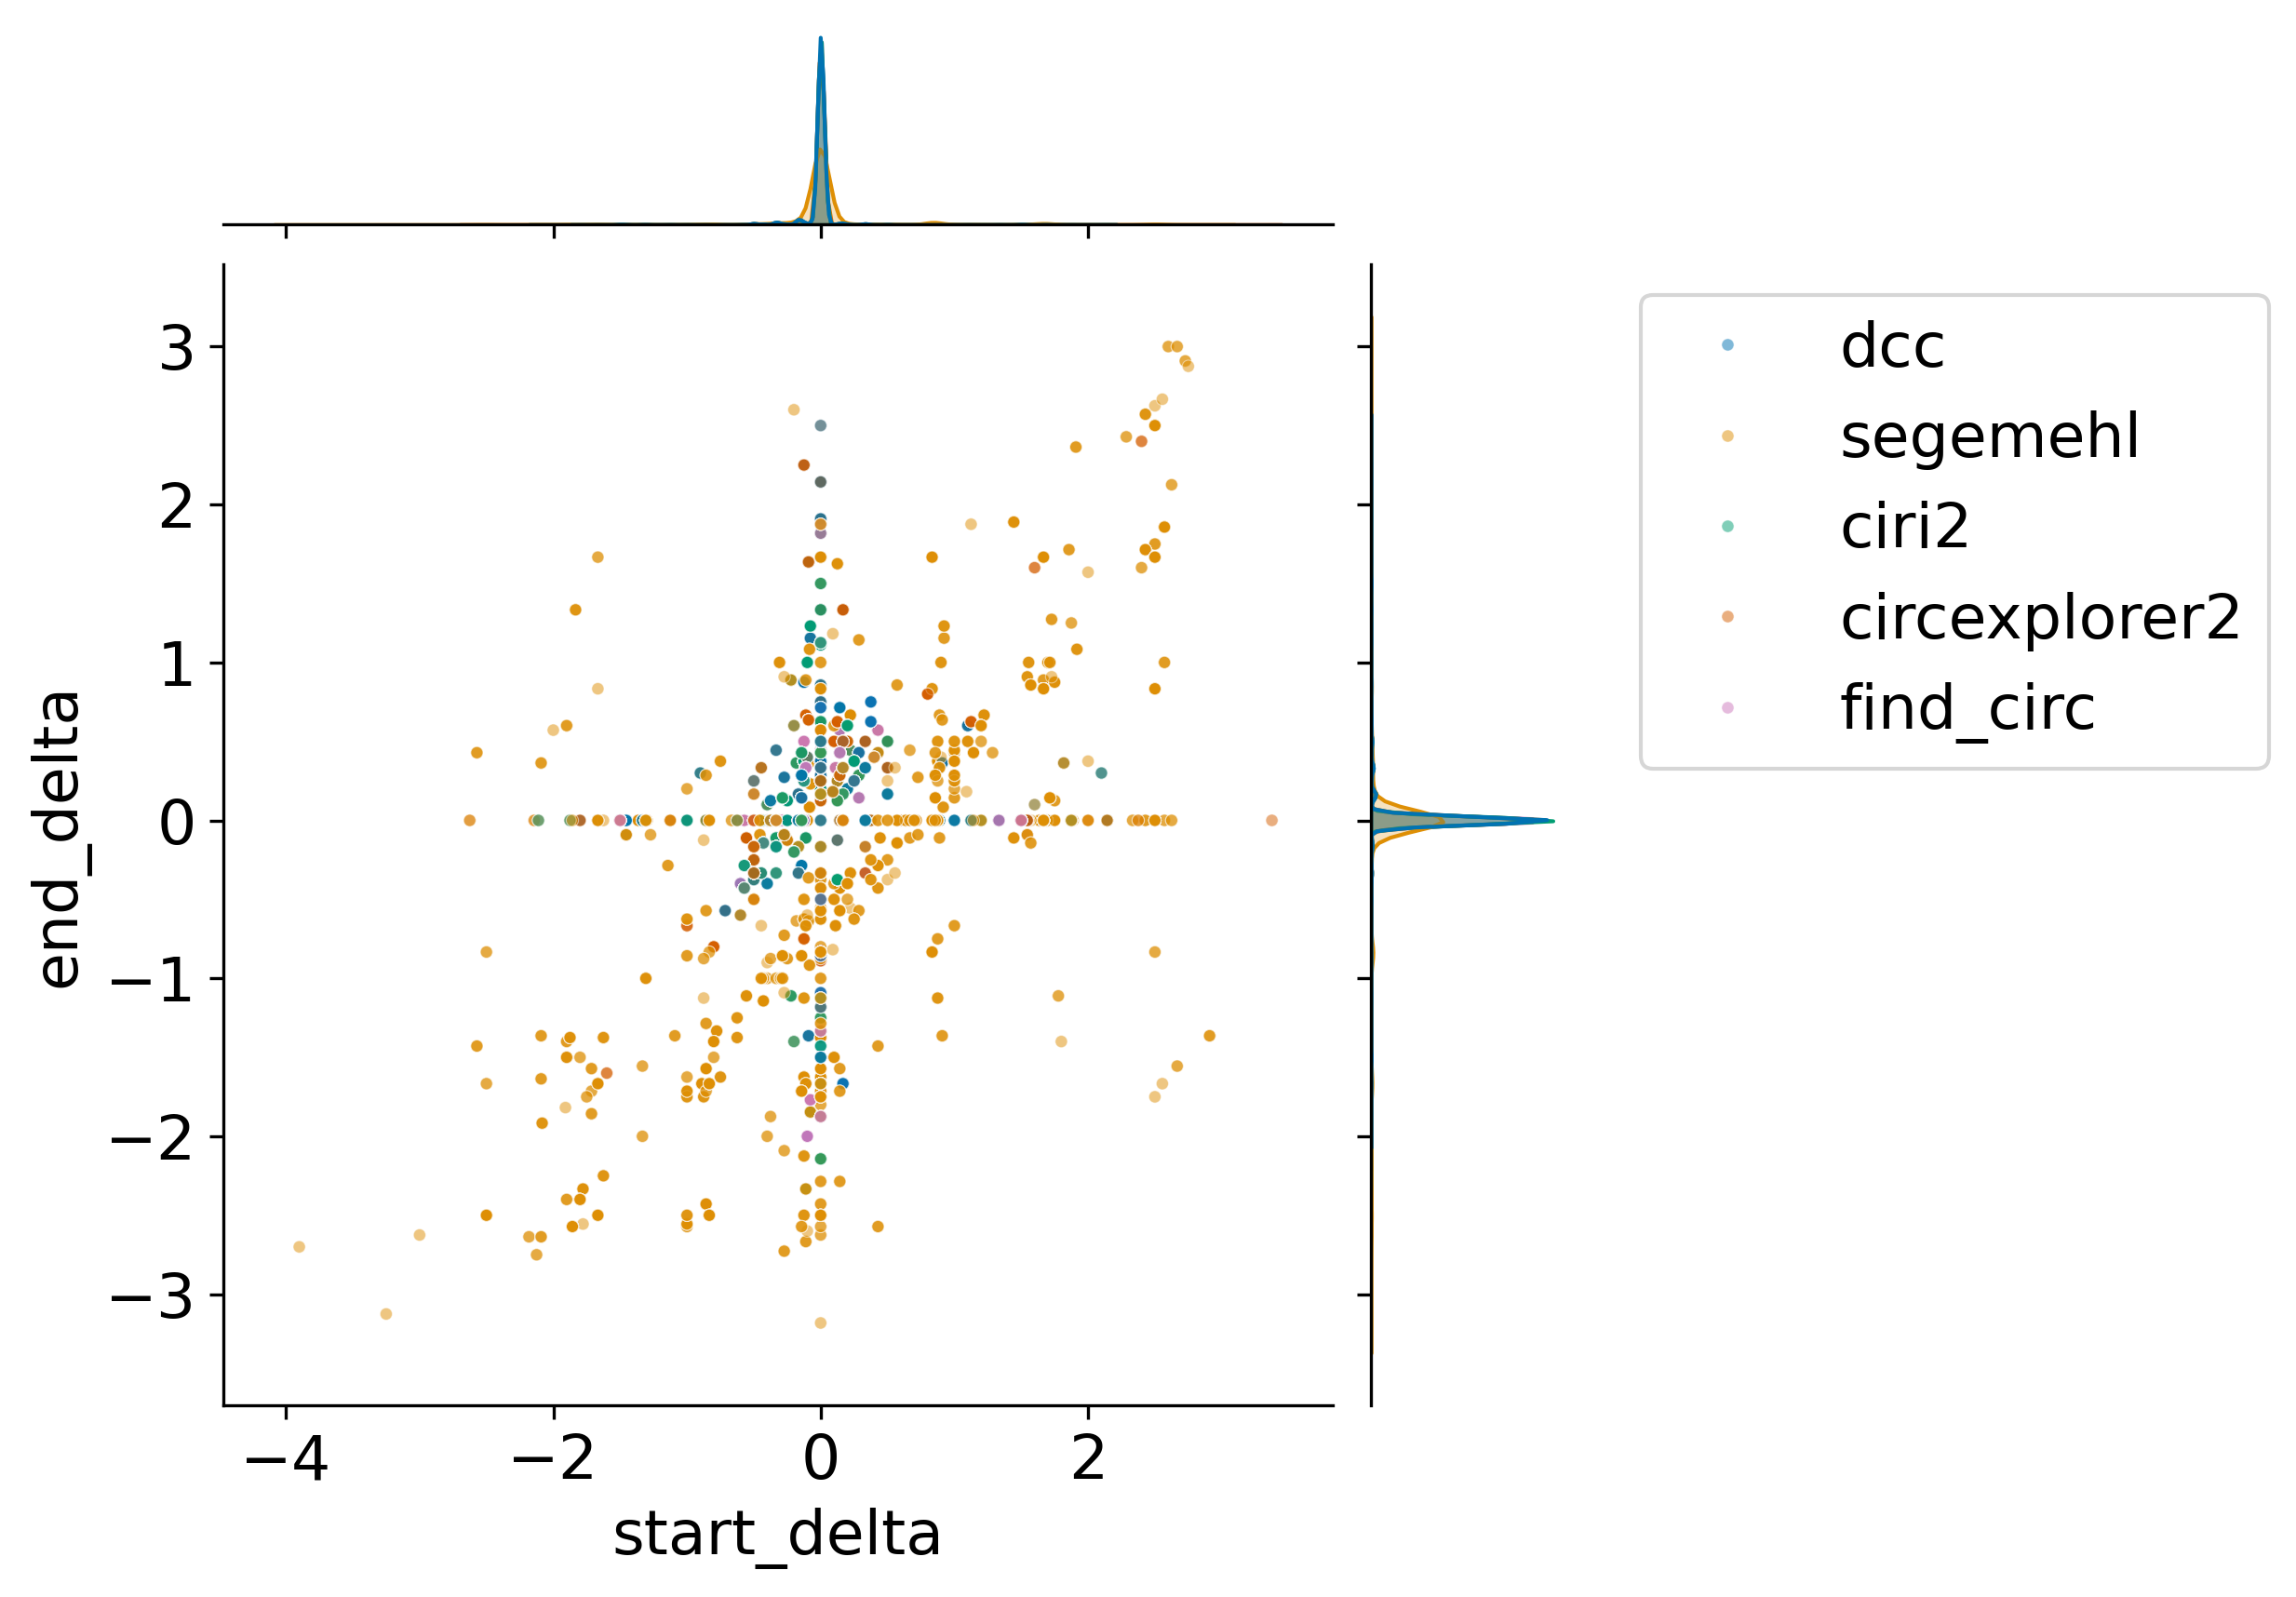

In [258]:
sns.jointplot(data=df, x="start_delta", y="end_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)

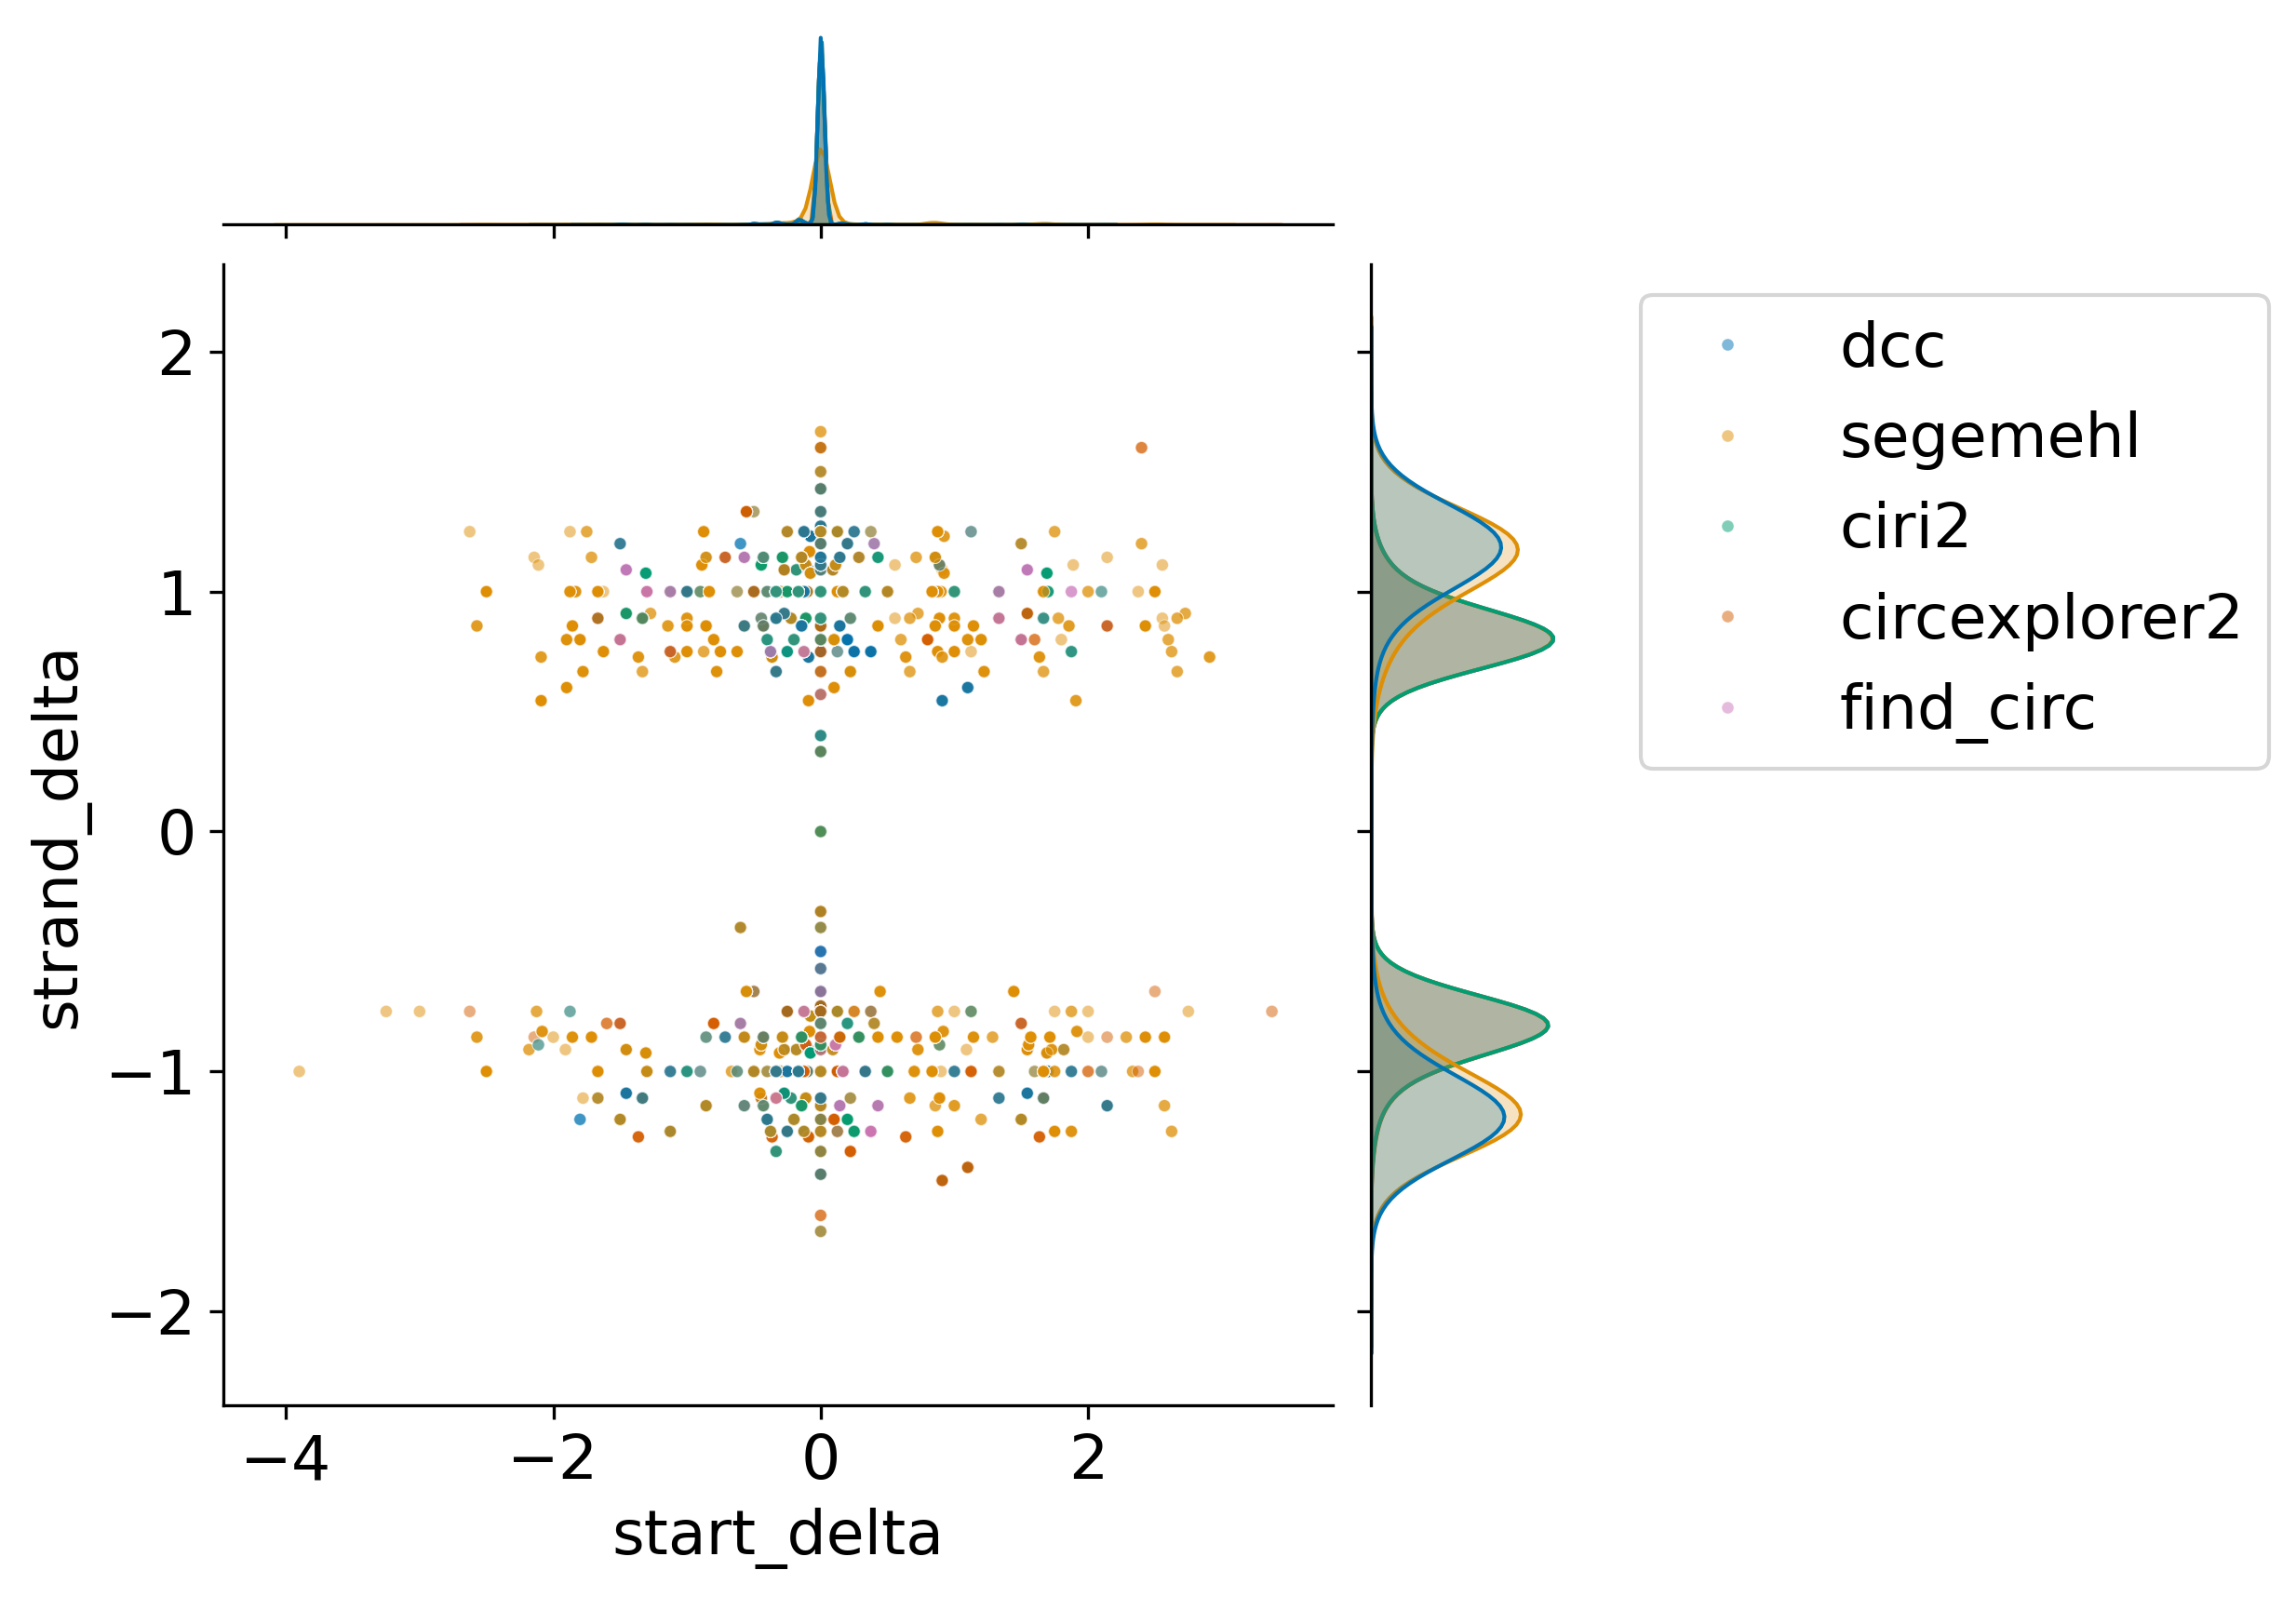

In [259]:
sns.jointplot(data=df, x="start_delta", y="strand_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)

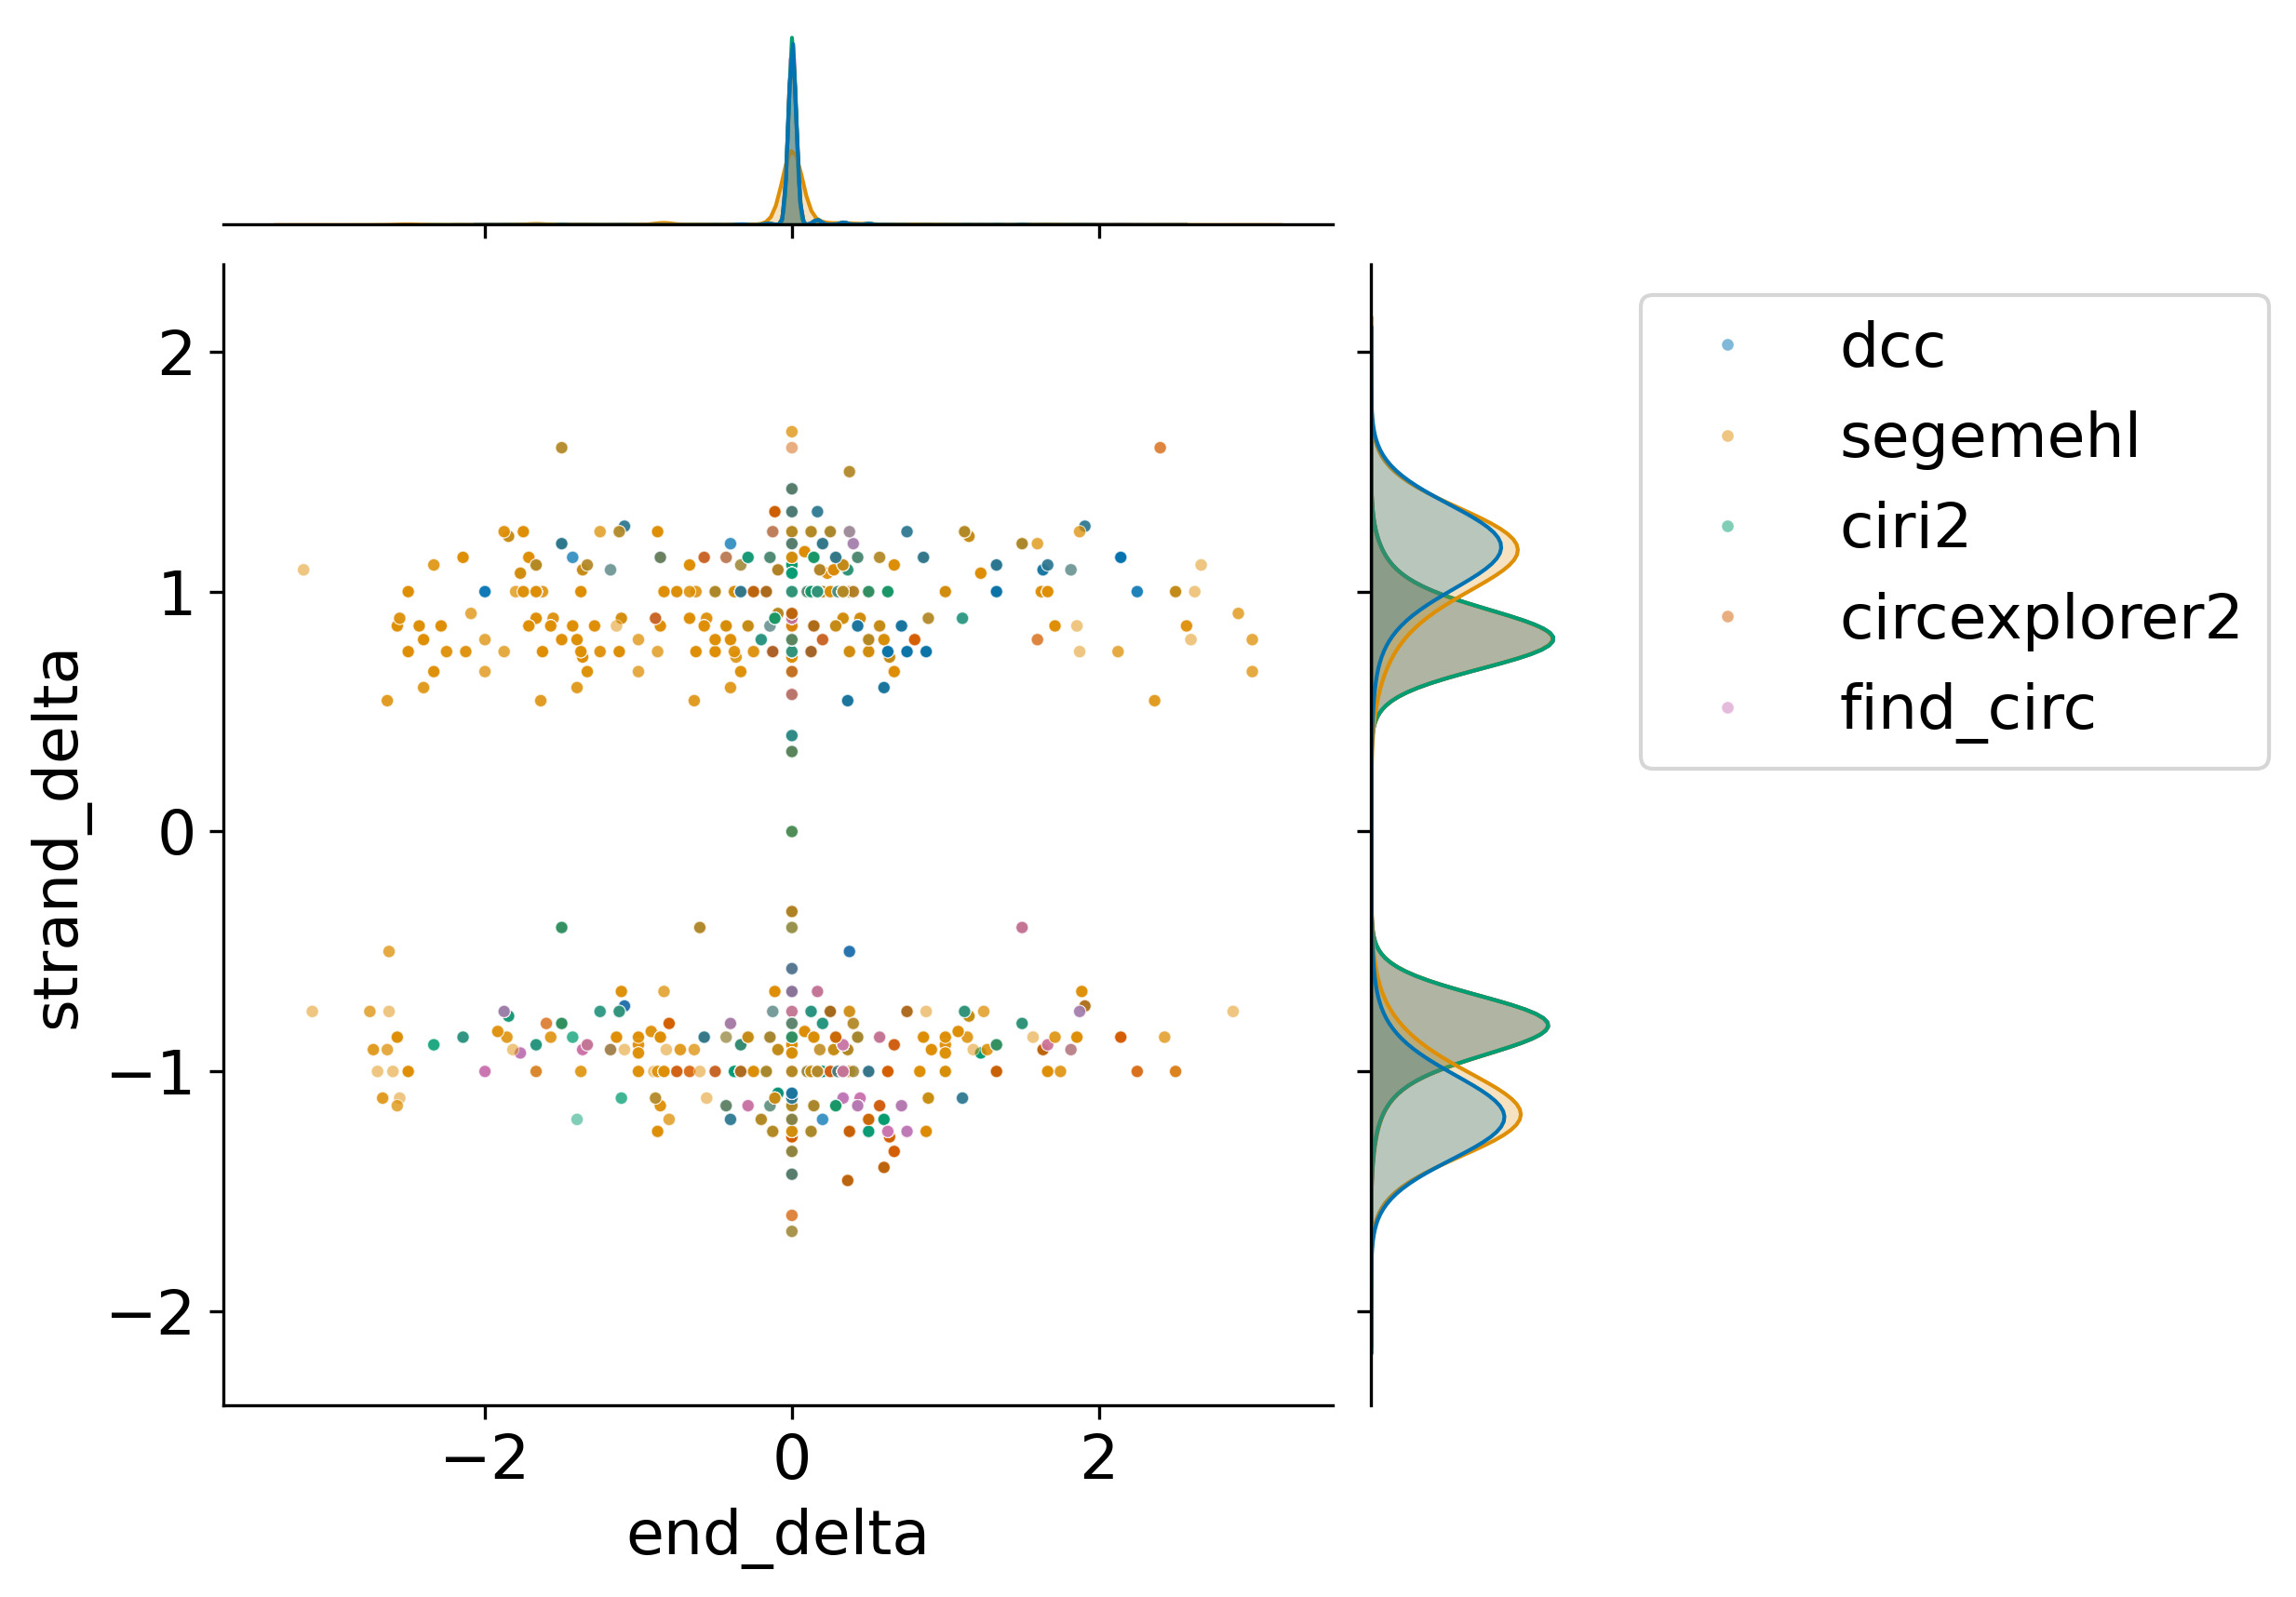

In [260]:
sns.jointplot(data=df, x="end_delta", y="strand_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)